In [1]:
import pandas as pd
import numpy as np
import matplotlib as mp

pd.set_option("display.max_columns", None)
df = pd.read_csv("../data/raw/retail_store_inventory.csv")
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [3]:
# Check the overall date range to confirm we have continuous daily data
df["Date"].min(), df["Date"].max()

('2022-01-01', '2024-01-01')

In [4]:
# See how many records exist per day (should be consistent across dates)
df["Date"].value_counts().sort_index().head()

Date
2022-01-01    100
2022-01-02    100
2022-01-03    100
2022-01-04    100
2022-01-05    100
Name: count, dtype: int64

In [5]:
# Check which columns have missing values and how many
df.isna().sum().sort_values(ascending=False)

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

In [6]:
# Identify cases where sales exceed inventory (likely stockouts)
(df["Units Sold"] > df["Inventory Level"]).sum()

np.int64(0)

In [7]:
# Preview examples where demand was higher than available inventory
df[df["Units Sold"] > df["Inventory Level"]].head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality


In [8]:
# Ensure there are no negative values in core inventory fields
(df[["Inventory Level", "Units Sold", "Units Ordered"]] < 0).sum()


Inventory Level    0
Units Sold         0
Units Ordered      0
dtype: int64

In [9]:
# Confirm how many unique SKUs exist (Store + Product combination)
df["Store ID"].astype(str).str.cat(df["Product ID"].astype(str), sep="_").nunique()

100

In [10]:
# Check how many days of data each SKU has
(
    df.assign(
        SKU=df["Store ID"].astype(str) + "_" + df["Product ID"].astype(str)
    )
    .groupby("SKU")["Date"]
    .count()
    .describe()
)

count    100.0
mean     731.0
std        0.0
min      731.0
25%      731.0
50%      731.0
75%      731.0
max      731.0
Name: Date, dtype: float64

In [11]:
# Review overall demand levels to catch obvious anomalies
df["Units Sold"].describe()

count    73100.000000
mean       136.464870
std        108.919406
min          0.000000
25%         49.000000
50%        107.000000
75%        203.000000
max        499.000000
Name: Units Sold, dtype: float64

<Axes: >

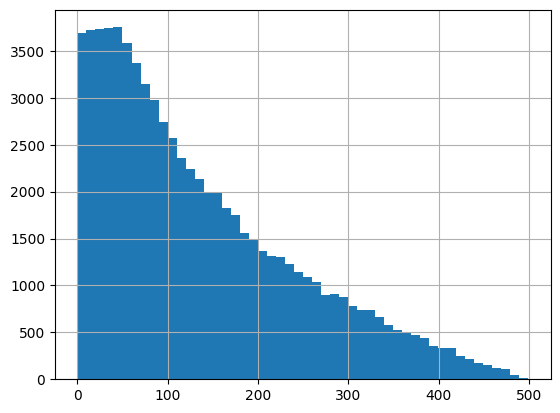

In [12]:
# Visualize the distribution of daily demand
df["Units Sold"].hist(bins=50)

In [13]:
# Review ordering behavior to understand replenishment patterns
df["Units Ordered"].describe()

count    73100.000000
mean       110.004473
std         52.277448
min         20.000000
25%         65.000000
50%        110.000000
75%        155.000000
max        200.000000
Name: Units Ordered, dtype: float64

In [14]:
# Check how often no replenishment order was placed
(df["Units Ordered"] == 0).mean()

np.float64(0.0)

In [16]:
# Create a SKU identifier (store + product)
df["SKU"] = df["Store ID"].astype(str) + "_" + df["Product ID"].astype(str)

In [18]:
# Aggregate daily data to SKU level
sku_summary = (
    df.groupby("SKU")
      .agg(
          **{
              "Total Units Sold": ("Units Sold", "sum"),
              "Avg Inventory Level": ("Inventory Level", "mean"),
              "Avg Daily Demand": ("Units Sold", "mean"),
              "Total Days": ("Date", "count"),
          }
      )
      .reset_index()
)

In [19]:
# Calculate inventory turnover (how efficiently inventory is used)
sku_summary["Inventory Turnover"] = (
    sku_summary["Total Units Sold"] /
    sku_summary["Avg Inventory Level"]
)


# Calculate days of inventory on hand (capital tied up in inventory)
sku_summary["Days Inventory On Hand"] = (
    sku_summary["Avg Inventory Level"] /
    sku_summary["Avg Daily Demand"]
)

In [20]:
# Review the resulting efficiency metrics
sku_summary.describe()

,Total Units Sold,Avg Inventory Level,Avg Daily Demand,Total Days,Inventory Turnover,Days Inventory On Hand
count,100.00000,100.000000,100.000000,100.0,100.000000,100.000000
mean,99755.82000,274.469877,136.464870,731.0,363.433290,2.012637
std,3361.63636,5.548751,4.598682,0.0,9.182992,0.050565
min,92556.00000,262.127223,126.615595,731.0,342.537938,1.862070
25%,97163.25000,270.389193,132.918263,731.0,356.824770,1.979374
50%,99811.00000,273.746922,136.540356,731.0,362.453581,2.016810
75%,101561.50000,277.973324,138.935021,731.0,369.308845,2.048627
max,109099.00000,290.865937,149.246238,731.0,392.573808,2.134070


In [22]:
# Calculate demand variability metrics at the SKU level
demand_variability = (
    df.groupby("SKU")
      .agg(
          **{
              "Avg Daily Demand": ("Units Sold", "mean"),
              "Demand Std Dev": ("Units Sold", "std"),
          }
      )
      .reset_index()
)

# Calculate coefficient of variation (risk relative to demand level)
demand_variability["Demand CV"] = (
    demand_variability["Demand Std Dev"] /
    demand_variability["Avg Daily Demand"]
)


# Review demand variability distribution
demand_variability.describe()

,Avg Daily Demand,Demand Std Dev,Demand CV
count,100.000000,100.000000,100.000000
mean,136.464870,108.859917,0.798128
std,4.598682,2.856704,0.019607
min,126.615595,102.240276,0.745605
25%,132.918263,107.046757,0.785865
50%,136.540356,108.635085,0.797414
75%,138.935021,111.200019,0.812000
max,149.246238,115.679314,0.837095


In [23]:
# Combine efficiency metrics and demand variability into one SKU-level table
sku_risk = (
    sku_summary.merge(
        demand_variability,
        on="SKU",
        how="inner"
    )
)

# Quick sanity check to confirm the merge worked as expected
sku_risk.shape, sku_risk["SKU"].nunique()

# Preview the combined table
sku_risk.head()

,SKU,Total Units Sold,Avg Inventory Level,Avg Daily Demand_x,Total Days,Inventory Turnover,Days Inventory On Hand,Avg Daily Demand_y,Demand Std Dev,Demand CV
0,S001_P0001,100371,272.824897,137.306430,731,367.895309,1.986978,137.306430,108.187859,0.787930
1,S001_P0002,95789,272.663475,131.038304,731,351.308514,2.080792,131.038304,104.313220,0.796051
2,S001_P0003,103393,274.543092,141.440492,731,376.600261,1.941050,141.440492,107.211225,0.757995
3,S001_P0004,103001,275.906977,140.904241,731,373.317852,1.958117,140.904241,113.644117,0.806534
4,S001_P0005,97318,269.325581,133.129959,731,361.339608,2.023028,133.129959,107.368873,0.806497


In [24]:
# Calculate percentile thresholds
cv_75 = sku_risk["Demand CV"].quantile(0.75)
inv_25 = sku_risk["Days Inventory On Hand"].quantile(0.25)

# Assign risk tiers
sku_risk["Risk Tier"] = "Low"

sku_risk.loc[
    (sku_risk["Demand CV"] >= cv_75) &
    (sku_risk["Days Inventory On Hand"] <= inv_25),
    "Risk Tier"
] = "High"

sku_risk.loc[
    (
        (sku_risk["Demand CV"] >= cv_75) &
        (sku_risk["Days Inventory On Hand"] > inv_25)
    ) |
    (
        (sku_risk["Demand CV"] < cv_75) &
        (sku_risk["Days Inventory On Hand"] <= inv_25)
    ),
    "Risk Tier"
] = "Medium"

# Review risk distribution
sku_risk["Risk Tier"].value_counts()

Risk Tier
Low       50
Medium    50
Name: count, dtype: int64

In [25]:
# Recalculate relaxed thresholds
cv_75 = sku_risk["Demand CV"].quantile(0.75)
inv_50 = sku_risk["Days Inventory On Hand"].quantile(0.50)
cv_25 = sku_risk["Demand CV"].quantile(0.25)
inv_75 = sku_risk["Days Inventory On Hand"].quantile(0.75)

# Default to Medium Risk
sku_risk["Risk Tier"] = "Medium"

# High Risk: high volatility + below-median inventory buffer
sku_risk.loc[
    (sku_risk["Demand CV"] >= cv_75) &
    (sku_risk["Days Inventory On Hand"] <= inv_50),
    "Risk Tier"
] = "High"

# Low Risk: low volatility or high inventory buffer
sku_risk.loc[
    (sku_risk["Demand CV"] <= cv_25) |
    (sku_risk["Days Inventory On Hand"] >= inv_75),
    "Risk Tier"
] = "Low"

# Review new distribution
sku_risk["Risk Tier"].value_counts()

Risk Tier
Low       49
Medium    43
High       8
Name: count, dtype: int64

In [26]:
# Save cleaned dataset to disk
df.to_csv("../data/clean/inventory_clean.csv", index=False)